# 4a) Image Retrieval
Assuming the presence of thousands of images within the map database, the task of determining the pose of a query image necessitates the **initial identification of similar images fastly**. This critical step is known as **image retrieval**. We start by loading required modules.

In [1]:
%load_ext autoreload
%autoreload 2
import random, time
import ipywidgets as widgets
from IPython.display import display
from collections import defaultdict
from pathlib import Path
from pprint import pformat
from hloc import (
    extract_features,
    match_features,
    pairs_from_covisibility,
    pairs_from_retrieval,
)
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization
from hloc.utils.downloader import *
from hloc.visualization import plot_images, read_image
from hloc.utils.parsers import group_and_sort_image_pairs_with_labels
from hloc.utils import viz_3d
from hloc.extract_features import ImageDataset

# Select the datbase and query image
Next, we select a few hundred images as database to attempt localizing a single image. This simulates, for instance, images of a floor in a building (such as a hospital where ARI robot operates). I have recorded the map **images of this floor**, which will serve as **our database images**. 

## Visualise the database images 
We will use approx. xxx images in the database from this floor.

[2024/02/08 10:36:19 hloc INFO] Found 24 images in root /data/grenoble/images/db.


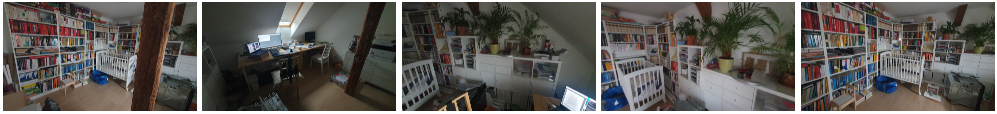

In [2]:
db_images_dir = Path("/data/grenoble/images/db")
db_images = ImageDataset(db_images_dir, {"resize_max": 1024}, None)
plot_images([read_image(db_images_dir / r) for r in random.sample(db_images.names, 5)], dpi=25)

## Visualise the query images 
Your task is to **capture query image(s)** with your phone and store it in **/data/grenoble/images/query**, which can be accomplished by using the script provided below. Upload the images using the "Upload" button and store it by "Save Image(s)".

In [3]:
query_images_dir = Path('/data/grenoble/images/query')
query_images_dir.mkdir(exist_ok=True, parents=True)

uploader = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=True  # Allow single file upload
)
save_button = widgets.Button(description="Save Image(s)")
save_button.on_click(lambda change: save_uploaded_file(uploader.value, query_images_dir))
display(uploader, save_button)

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Button(description='Save Image(s)', style=ButtonStyle())

After uploading and saving the images, try to show them, i.e., verify that they are ready for image retrieval.

[2024/02/08 10:36:33 hloc INFO] Found 1 images in root /data/grenoble/images/query.


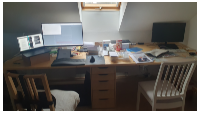

In [4]:
query_images = ImageDataset(query_images_dir, {"resize_max": 1024}, None)
plot_images([read_image(query_images_dir / r) for r in random.sample(query_images.names, min([len(query_images.names), 10]))], dpi=25)

# [OFFLINE] Describe database images
We first select the image descriptor and describe all the images in the database by feature vectors.

In [13]:
retrieval_conf = extract_features.confs['dir']       # dir, netvlad, openibl, eigenplaces, senet

In [14]:
outputs = Path("outputs/aachen")
global_descriptors = extract_features.main(retrieval_conf, db_images_dir, outputs)

[2024/02/08 10:37:55 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'dir'},
 'output': 'global-feats-dir',
 'preprocessing': {'resize_max': 1024}}
[2024/02/08 10:37:55 hloc INFO] Found 24 images in root /data/grenoble/images/db.
Downloading...
From (original): https://docs.google.com/uc?export=download&id=1UWJGDuHtzaQdFhSMojoYVQjmCXhIwVvy
From (redirected): https://docs.google.com/uc?export=download&id=1UWJGDuHtzaQdFhSMojoYVQjmCXhIwVvy&confirm=t&uuid=e000503e-5724-4742-81a3-950b493d4ac3
To: /root/.cache/torch/hub/dirtorch/Resnet-101-AP-GeM.pt.zip
100%|███████████████████████████████████████████████████████| 539M/539M [00:10<00:00, 51.3MB/s]
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.20.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence

=> loading checkpoint '/root/.cache/torch/hub/dirtorch/Resnet-101-AP-GeM.pt' (current_iter 296)


100%|██████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  5.29it/s]
[2024/02/08 10:38:14 hloc INFO] Finished exporting features.


# [ONLINE] Describe query images

In [15]:
start_time = time.time()
global_descriptors = extract_features.main(retrieval_conf, query_images_dir, outputs)
print(f"Elapsed time: {(time.time() - start_time):.2f} seconds")

[2024/02/08 10:38:17 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'dir'},
 'output': 'global-feats-dir',
 'preprocessing': {'resize_max': 1024}}
[2024/02/08 10:38:17 hloc INFO] Found 1 images in root /data/grenoble/images/query.


=> loading checkpoint '/root/.cache/torch/hub/dirtorch/Resnet-101-AP-GeM.pt' (current_iter 296)


100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]
[2024/02/08 10:38:18 hloc INFO] Finished exporting features.


Elapsed time: 0.94 seconds


# [ONLINE] Find the pairs between the query and database images
Here we use the prefix in the directory paths "db" and "query" to distinguish between database and query images. This script finds **num_matched** most similar database images for a query image. 

In [18]:
num_matched_images = 5
db_images = ImageDataset(db_images_dir, {"resize_max": 1024}, None)
query_images = ImageDataset(query_images_dir, {"resize_max": 1024}, None)

[2024/02/08 10:39:29 hloc INFO] Found 24 images in root /data/grenoble/images/db.
[2024/02/08 10:39:29 hloc INFO] Found 1 images in root /data/grenoble/images/query.


In [19]:
start_time = time.time()
loc_pairs = outputs / (f"pairs-query-netvlad{num_matched_images}.txt")  # top k retrieved by NetVLAD
pairs = pairs_from_retrieval.main(
    global_descriptors, loc_pairs, num_matched=num_matched_images, db_list=db_images.names, query_list=query_images.names
)
print(f"Elapsed time: {(time.time() - start_time):.2f} seconds")

[2024/02/08 10:39:29 hloc INFO] Extracting image pairs from a retrieval database.
[2024/02/08 10:39:29 hloc INFO] Found 5 pairs.


Elapsed time: 0.04 seconds


# Visualise retrieved images
We have found similar images, let's look at them in the order from largest similarity to the smalles similarity. The similarity is the dot product between the image feature vectors.

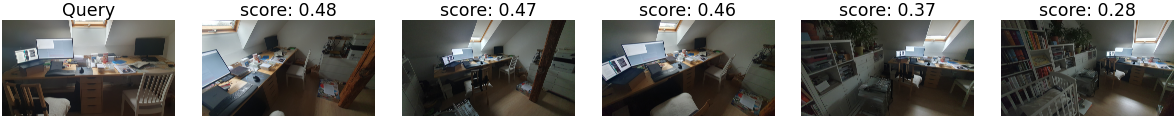

In [20]:
grouped_and_sorted_with_labels = group_and_sort_image_pairs_with_labels(pairs)

for query, db_images in grouped_and_sorted_with_labels.items():
    retrieved_images = [query_images_dir / query] + [db_images_dir / img[0] for img in db_images]
    labels = ["Query"] + [img[2] for img in db_images]  # "Query" for the first, and "db - score" for the rest
    plot_images([read_image(r) for r in retrieved_images], titles=labels, dpi=25, figsize=4.5, title_fontsize=50)